## Generate word2vec embeddings using TensorFlow

Use Noise Contrastive Estimator (NCE) as a loss function

#### Some imports to make code compatible with Python 2 as well as 3

In [1]:
import collections
import math
import os
import random
import zipfile

In [2]:
from six.moves import urllib
from six.moves import xrange

In [3]:
import numpy as np
import tensorflow as tf

/home/mayank/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
DOWNLOADED_FILENAME = 'SampleText.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    statinfo = os.stat(DOWNLOADED_FILENAME)

    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path: ', url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)

        raise Exception(
            'Failed to verify file from: ' + url_path + '. Can you get to it with a browser?')

In [5]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    
    return words

In [6]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016

maybe_download(URL_PATH, FILESIZE)

Found and verified file from this path:  http://mattmahoney.net/dc/text8.zip
Downloaded file:  SampleText.zip


#### Get the list of words from the the sample, this is our entire vocabulary

In [7]:
vocabulary = read_words()

In [8]:
len(vocabulary)

17005207

In [9]:
vocabulary[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

### Build the data set used to generate word2vec embeddings

* *words* A list of all words in the input dataset
* *n_words* The number of words to include in the dataset. We use the most frequently occurring n_words

Return values are:

* *word_counts* The most frequently occurring words and the corresponding frequencies
* *word_indexes* The list of index values which uniquely identifies each word in the dataset
* *dictionary* Mapping from a word to its unique index
* *reversed_dictionary* Mapping from the unique index to the word

In [10]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
 
    # Only the most common words are added to the dictionary
    dictionary = dict()
    
    for word, _ in word_counts:
        # The current length of the dictionary is the unique index of this word
        # added to the dictionary
        dictionary[word] = len(dictionary)
    
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNKNOWN']
            unknown_count += 1
        
        word_indexes.append(index)
    
    # Count of unknown words
    word_counts[0][1] = unknown_count
    
    # Map from unique indexes to word
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return  word_counts, word_indexes, dictionary, reversed_dictionary

In [11]:
VOCABULARY_SIZE = 100000

word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [12]:
word_counts[:10]

[['UNKNOWN', 189230],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [13]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [14]:
i = 0
for key in dictionary:
    if i < 10:
        print(key, ' : ', dictionary[key])
    else:
        break
    i += 1

UNKNOWN  :  0
the  :  1
of  :  2
and  :  3
one  :  4
in  :  5
a  :  6
to  :  7
zero  :  8
nine  :  9


In [15]:
i = 0
for key in reversed_dictionary:
    if i < 10:
        print(key, ' : ', reversed_dictionary[key])
    else:
        break
    i += 1

0  :  UNKNOWN
1  :  the
2  :  of
3  :  and
4  :  one
5  :  in
6  :  a
7  :  to
8  :  zero
9  :  nine


#### A hint to the Python interpreter that vocabulary can be deleted

In [16]:
del vocabulary

### Return one batch of data and the corresponding labels for training

* *word_indexes* A list of unique indexes which identifies each word in the dataset. The most popular words have the lowest index values
* *batch_size* The number of elements in each batch
* *num_skips* The number of words to choose from the neighboring words within the skip_window. Each input word will appear num_skips times in the batch with a context or neighboring word as the corresponding label
* *skip_window* How many words to consider around one input word

In [17]:
# Global index into words maintained across batches
global_index = 0

def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index

    # For every input we find num_skips context words within a window
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # batch = [1, 2, 3, .... batch_size]
    # labels = [[1], [2], [3], ..., [batch_size]]
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The span of a window includes the skip_window elements on each side
    # of the input word plus the word itself
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]

    # A deque is double-ended queue which supports memory efficient appends
    # and pops from each side
    buffer = collections.deque(maxlen=span)

    # Initialize the deque with the first words in the deque
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]

        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            labels[i * num_skips + j, 0] = buffer[target]  # these are the context words
        
        # The first word from the buffer is removed automatically when a new word
        # is added in at the end
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    # Backtrack a little bit to avoid skipping words in the end of a batch, these
    # words will be captured in the next batch
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)

    return batch, labels

In [18]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [19]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156],
      dtype=int32)

In [20]:
labels

array([[ 12],
       [128],
       [ 12],
       [128],
       [ 12],
       [  6],
       [  2],
       [  6],
       [742],
       [477]], dtype=int32)

In [21]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ": ", reversed_dictionary[labels[i][0]])

of :  as
of :  early
abuse :  as
abuse :  early
first :  as
first :  a
used :  of
used :  a
against :  working


### Initialize some variables to build and train the skip-gram model

* *batch_size*: The size of the batch to use in training
* *embedding_size*: Dimensions of the embedding vector i.e. how many features we use to represent a word
* *skip_window*: How many words to include in the context, this is to the left and right
* *num_skips*: How many context words to associate with each target word

In [22]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

# Reset the global index because we updated while testing the batch code
global_index = 0

### Choose some words at random to validate our trained model

* *valid_size*: Number of words to evaluate our model, we'll use these words to see how similar the closest words are
* *valid_window*: The window from where we draw the words to run validation on, only pick from the most commonly used words

Choose the set of words from the top 100 at random

In [23]:
valid_size = 16  
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

### Number of negative examples to sample for NCE loss calculation

In [24]:
num_samples = 64

### Input placeholder to feed data in batches

In [25]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

### Set up a constant to hold validation data

In [26]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Embeddings are word representations that will be generated by word2vec

Initialize a variable to hold the embeddings and embeddings for specific words can be accessed using *tf.nn.embedding_lookup*

NOTE: Embeddings and NCE losses only work on the CPU in TensorFlow, GPU support has not been added yet

In [27]:
embeddings = tf.Variable(
    tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### Construct weights and biases to hold the NCE (Noise Contrastive Estimation) loss

In [28]:
nce_weights = tf.Variable(
    tf.truncated_normal([VOCABULARY_SIZE, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [29]:
loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_samples,
                     num_classes=VOCABULARY_SIZE))

In [30]:
 optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

### Normalize the embeddings vector to calculate cosine similarity between words

*normalized_vector = vector / L2 norm of vector*

In [31]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / l2_norm

Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Look up the normalized embeddings of the words we use to validate our model

In [32]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

#### Find the cosine similarity of the validation words against all words in our vocabulary

In [33]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [34]:
init = tf.global_variables_initializer()

In [35]:
num_steps = 200001

In [36]:
final_embeddings = None

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            word_indexes, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
            
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  283.4246520996094
Nearest to they: snodgrass, neptune, federko, boliviano, talionis, elaine, hessen, decays,
Nearest to so: watersports, lanois, gaulois, salish, pardubice, carries, inklings, eridani,
Nearest to years: ltte, colonists, motd, circumvention, lazarus, pfx, yogurt, bran,
Nearest to also: nadi, defecating, handbooks, keppel, pusyamitra, clays, stokowski, phillipe,
Nearest to zero: umma, dayak, cathy, inhaling, midshipmen, furrer, mckernan, course,
Nearest to were: oke, sosa, merz, fortean, immovable, stewards, purview, mozilla,
Nearest to history: miaou, maimonides, canopy, tiefland, cosmas, smoothness, hatti, fuzion,
Nearest to war: saith, matriarchy, psk, neuwirth, laayoune, consanguinity, demo, pacelli,
Nearest to many: ney, preregular, biogeochemistry, aryas, gee, juhani, registers, dorn,
Nearest to state: ludwigs, jawaharlal, nhsda, lauded, swivel, ehyeh, nethack, relent,
Nearest to use: lentini, lois, waren, applauded, subdivision, opanal, l

Average loss at step  82000 :  6.074146396756172
Average loss at step  84000 :  5.934203751683235
Average loss at step  86000 :  5.9831751190423965
Average loss at step  88000 :  5.892832245945931
Average loss at step  90000 :  5.867488554954528
Average loss at step  92000 :  5.612831126332283
Average loss at step  94000 :  5.812993908286095
Average loss at step  96000 :  5.7095862938165665
Average loss at step  98000 :  5.541099781990051
Average loss at step  100000 :  5.868656190156937
Nearest to they: we, he, you, still, wirtschaft, but, not, kilograms,
Nearest to so: if, cra, economically, when, akh, retractable, serpentine, vma,
Nearest to years: smyrnaeans, whales, arctos, universalistic, sepulchre, syllable, fulham, settle,
Nearest to also: which, often, heinz, however, although, randomness, sometimes, mathit,
Nearest to zero: five, three, two, four, seven, eight, six, cra,
Nearest to were: are, was, himself, both, many, being, acrylics, ngler,
Nearest to history: city, olympias

Average loss at step  182000 :  5.082147632598877
Average loss at step  184000 :  5.166925644397735
Average loss at step  186000 :  5.002733458280563
Average loss at step  188000 :  5.039064165830612
Average loss at step  190000 :  5.097813142180443
Average loss at step  192000 :  5.10727058762312
Average loss at step  194000 :  5.060922000527382
Average loss at step  196000 :  5.011830651640892
Average loss at step  198000 :  5.021741526246071
Average loss at step  200000 :  4.870829917311668
Nearest to they: we, you, he, wirtschaft, she, anchorage, there, marne,
Nearest to so: if, simply, cra, when, though, however, augustana, but,
Nearest to years: days, universalistic, smyrnaeans, whales, unheralded, sepulchre, period, universe,
Nearest to also: which, sometimes, preposition, heinz, now, actually, still, often,
Nearest to zero: five, two, four, three, seven, abet, wct, eurocents,
Nearest to were: are, was, being, many, had, those, auxin, nativity,
Nearest to history: modern, era, l

In [37]:
def save_words_embeddings(embeddings, word_counts):    
    np.save('embeddings.npy', embeddings)    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
    
save_words_embeddings(final_embeddings, word_counts)

# ### Visualize the embeddings

In [38]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)

        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)
    plt.show(filename)

In [39]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

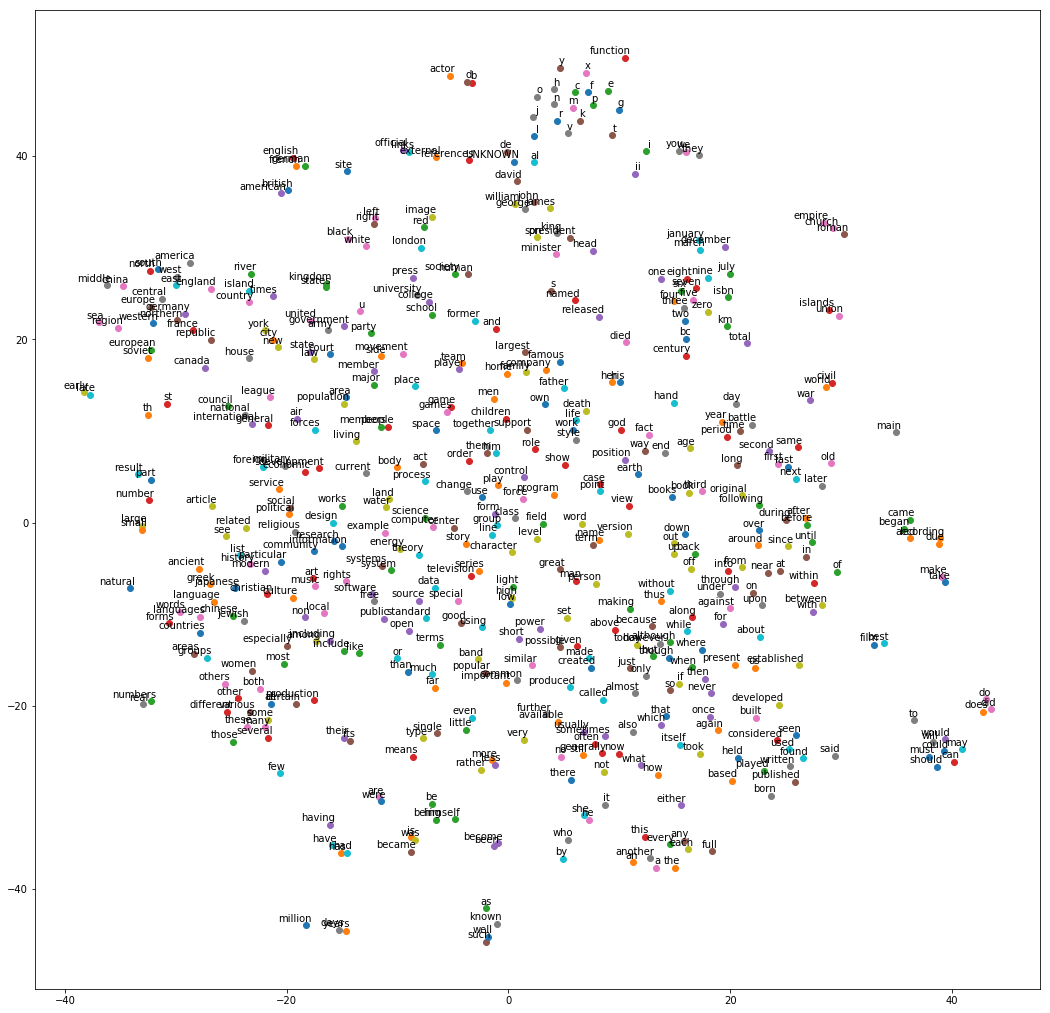

In [40]:
plot_with_labels(low_dim_embs, labels)